
# SVM with scikit-learn — Step-by-Step Labs (Entry → Medium → Advanced)

**What you'll learn**
- Intuition of SVM (margin, kernels, support vectors)
- Hands-on binary & multiclass classification
- Manual scaling (no `Pipeline`), train/val/test splits
- Hyperparameter tuning by hand
- Regression with SVR
- Imbalanced data handling

> **Note:** We intentionally avoid `Pipeline` to make each step explicit for beginners.


In [1]:

# If needed, install packages in your environment (uncomment if missing)
# !pip install scikit-learn matplotlib numpy
%matplotlib inline
import numpy as np, matplotlib.pyplot as plt
print("Ready!")


Ready!



## How SVMs work (super quick refresher)
- **Goal**: find a hyperplane that separates classes with the **largest margin**.
- **Kernels**: `linear` (straight line/plane), `rbf` (curvy), `poly` (polynomial).
- **Key hyperparameters**: `C` (regularization), `gamma` (RBF/poly), and for SVR `epsilon`.
- **Always scale features** for SVMs. We'll do it **manually** (fit scaler on train only).


### Helper for 2D decision boundary (used in Entry labs)

In [2]:

import numpy as np
import matplotlib.pyplot as plt

def plot_svm_2d(clf, X, y, scaler=None, title='SVM decision boundary'):
    # X here is the ORIGINAL (unscaled) data used for plotting axes.
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 400),
                         np.linspace(y_min, y_max, 400))
    grid = np.c_[xx.ravel(), yy.ravel()]
    grid_scaled = scaler.transform(grid) if scaler is not None else grid

    Z = clf.decision_function(grid_scaled).reshape(xx.shape)

    plt.figure(figsize=(6, 5))
    plt.contourf(xx, yy, Z > 0, alpha=0.2)
    cs = plt.contour(xx, yy, Z, levels=[-1, 0, 1], linewidths=1.5)
    plt.clabel(cs, inline=True, fontsize=8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=30, edgecolor='k')
    if hasattr(clf, "support_vectors_"):
        sv = clf.support_vectors_
        sv_orig = scaler.inverse_transform(sv) if scaler is not None else sv
        plt.scatter(sv_orig[:, 0], sv_orig[:, 1],
                    s=120, facecolors='none', edgecolors='k',
                    linewidths=1.5, label='Support Vectors')
        plt.legend()
    plt.title(title)
    plt.show()



---
# Entry Level



## Lab E1 — Linear SVM on easy blobs (binary)
**Concept**: maximum-margin & effect of `C`.  
**Data**: synthetic 2D blobs.


Accuracy: 1.000
Support vectors used: 2


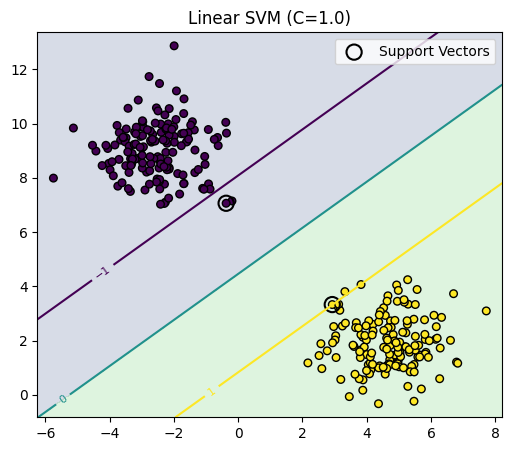

C=0.1  | test acc=1.000 | #SV=14
C=1    | test acc=1.000 | #SV=2
C=10   | test acc=1.000 | #SV=2


In [3]:

import numpy as np
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# 1) Data
X, y = make_blobs(n_samples=300, centers=2, cluster_std=1.0, random_state=42)

# 2) Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y)

# 3) Scale (fit on TRAIN only)
scaler = StandardScaler().fit(X_train)
X_train_s = scaler.transform(X_train)
X_test_s  = scaler.transform(X_test)

# 4) Train
clf = SVC(kernel='linear', C=1.0, random_state=42)
clf.fit(X_train_s, y_train)

# 5) Evaluate
pred = clf.predict(X_test_s)
acc = accuracy_score(y_test, pred)
print(f"Accuracy: {acc:.3f}")
print("Support vectors used:", clf.support_vectors_.shape[0])

# 6) Visualize
plot_svm_2d(clf, X, y, scaler=scaler, title='Linear SVM (C=1.0)')

# 7) Try different C values
for C in [0.1, 1, 10]:
    m = SVC(kernel='linear', C=C, random_state=42).fit(X_train_s, y_train)
    print(f"C={C:<4} | test acc={accuracy_score(y_test, m.predict(X_test_s)):.3f} | "
          f"#SV={m.support_vectors_.shape[0]}")



## Lab E2 — Nonlinear SVM (RBF) on moons (binary)
**Concept**: why we need kernels; role of `gamma`.  
**Data**: 2D moons.


Accuracy: 0.8933333333333333


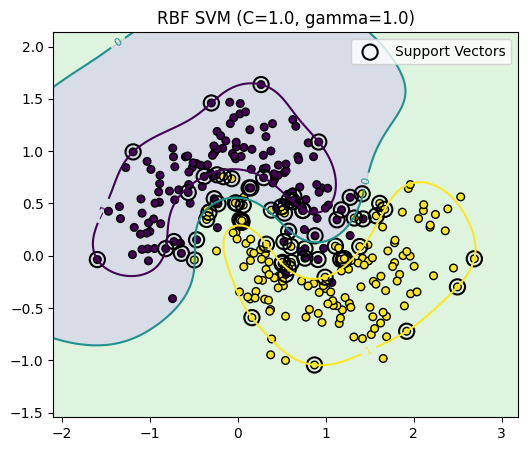

gamma=0.1  -> test acc=0.840 | #SV=85
gamma=0.5  -> test acc=0.893 | #SV=72
gamma=1    -> test acc=0.893 | #SV=69
gamma=5    -> test acc=0.907 | #SV=104


In [4]:

from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# 1) Data
X, y = make_moons(n_samples=300, noise=0.25, random_state=42)

# 2) Split & scale
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y)

scaler = StandardScaler().fit(X_train)
X_train_s = scaler.transform(X_train)
X_test_s  = scaler.transform(X_test)

# 3) Train RBF SVM
clf = SVC(kernel='rbf', C=1.0, gamma=1.0, random_state=42)
clf.fit(X_train_s, y_train)

# 4) Evaluate + visualize
print("Accuracy:", accuracy_score(y_test, clf.predict(X_test_s)))
plot_svm_2d(clf, X, y, scaler=scaler, title='RBF SVM (C=1.0, gamma=1.0)')

# 5) Effect of gamma
for gamma in [0.1, 0.5, 1, 5]:
    m = SVC(kernel='rbf', C=1.0, gamma=gamma, random_state=42).fit(X_train_s, y_train)
    acc = accuracy_score(y_test, m.predict(X_test_s))
    print(f"gamma={gamma:<4} -> test acc={acc:.3f} | #SV={m.support_vectors_.shape[0]}")



---
# Medium Level



## Lab M1 — Multiclass Iris (report + confusion matrix)
**Concepts**: multiclass (one-vs-one), standardization, interpreting confusion matrix.  
**Data**: Iris (3 classes).


              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        12
  versicolor       0.92      0.92      0.92        13
   virginica       0.92      0.92      0.92        13

    accuracy                           0.95        38
   macro avg       0.95      0.95      0.95        38
weighted avg       0.95      0.95      0.95        38



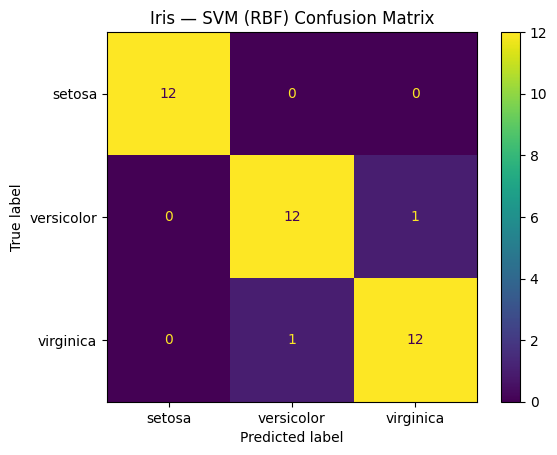

In [5]:

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

data = load_iris()
X, y = data.data, data.target

Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
scaler = StandardScaler().fit(Xtr)
Xtr_s, Xte_s = scaler.transform(Xtr), scaler.transform(Xte)

clf = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
clf.fit(Xtr_s, ytr)

print(classification_report(yte, clf.predict(Xte_s), target_names=data.target_names))

ConfusionMatrixDisplay.from_estimator(clf, Xte_s, yte,
                                      display_labels=data.target_names,
                                      values_format='d')
plt.title("Iris — SVM (RBF) Confusion Matrix")
plt.show()



## Lab M2 — Breast cancer (manual hyperparameter search + ROC)
**Concepts**: proper scaling; manual train/val/test; tune `C` & `gamma` without Pipelines; ROC AUC.


Best on validation: AUC=0.9990 with C=30, gamma=0.01
Test AUC: 0.9967


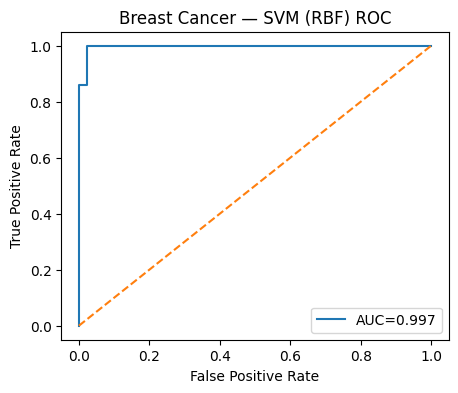

In [6]:

import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# 1) Load
data = load_breast_cancer()
X, y = data.data, data.target  # binary: malignant vs benign

# 2) Split train/val/test (60/20/20)
X_tmp, X_test, y_tmp, y_test = train_test_split(X, y, test_size=0.2,
                                                random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_tmp, y_tmp, test_size=0.25,
                                                  random_state=42, stratify=y_tmp)
# 3) Scale using ONLY training
scaler = StandardScaler().fit(X_train)
Xs_tr = scaler.transform(X_train)
Xs_val = scaler.transform(X_val)
Xs_te  = scaler.transform(X_test)

# 4) Manual grid search on validation set
best_auc, best_params, best_model = -np.inf, None, None
for C in [0.1, 1, 3, 10, 30, 100]:
    for gamma in [0.01, 0.03, 0.1, 0.3, 1, 'scale']:
        clf = SVC(kernel='rbf', C=C, gamma=gamma, random_state=42)
        clf.fit(Xs_tr, y_train)
        scores_val = clf.decision_function(Xs_val)  # continuous scores
        auc_val = roc_auc_score(y_val, scores_val)
        if auc_val > best_auc:
            best_auc, best_params, best_model = auc_val, (C, gamma), clf

print(f"Best on validation: AUC={best_auc:.4f} with C={best_params[0]}, gamma={best_params[1]}")

# 5) Refit on TRAIN+VAL with a fresh scaler (no leakage)
X_trval = np.vstack([X_train, X_val])
y_trval = np.hstack([y_train, y_val])
scaler2 = StandardScaler().fit(X_trval)
Xs_trval = scaler2.transform(X_trval)
Xs_te2   = scaler2.transform(X_test)

final = SVC(kernel='rbf', C=best_params[0], gamma=best_params[1], random_state=42)
final.fit(Xs_trval, y_trval)

# 6) Test ROC curve
scores_te = final.decision_function(Xs_te2)
fpr, tpr, thr = roc_curve(y_test, scores_te)
auc_test = roc_auc_score(y_test, scores_te)
print(f"Test AUC: {auc_test:.4f}")

plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f"AUC={auc_test:.3f}")
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("Breast Cancer — SVM (RBF) ROC")
plt.legend(); plt.show()



## Lab M3 — Handwritten digits with LinearSVC (fast multiclass)
**Concepts**: high-dimensional multiclass, linear SVM, standardization.


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        45
           1       0.93      0.89      0.91        46
           2       1.00      1.00      1.00        44
           3       0.98      0.96      0.97        46
           4       0.94      1.00      0.97        45
           5       0.94      0.96      0.95        46
           6       0.93      0.96      0.95        45
           7       0.94      0.98      0.96        45
           8       0.90      0.88      0.89        43
           9       0.95      0.89      0.92        45

    accuracy                           0.95       450
   macro avg       0.95      0.95      0.95       450
weighted avg       0.95      0.95      0.95       450



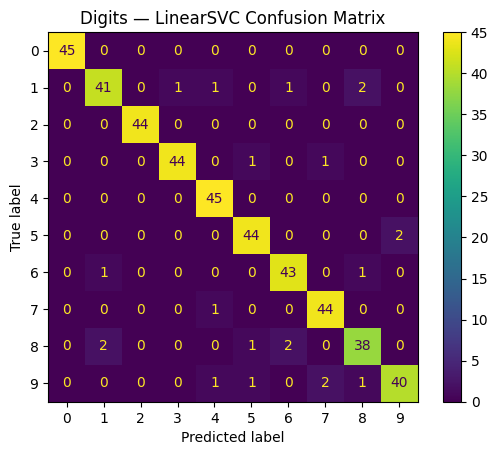

In [7]:

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

digits = load_digits()
X, y = digits.data, digits.target

Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
scaler = StandardScaler().fit(Xtr)  # (0..16 pixel values → scale helps)
Xtr_s, Xte_s = scaler.transform(Xtr), scaler.transform(Xte)

clf = LinearSVC(C=1.0, dual=False, max_iter=10000, tol=1e-4, random_state=42)
clf.fit(Xtr_s, ytr)

print(classification_report(yte, clf.predict(Xte_s)))

ConfusionMatrixDisplay.from_estimator(clf, Xte_s, yte)
plt.title("Digits — LinearSVC Confusion Matrix")
plt.show()



---
# Advanced Level



## Lab A1 — Support Vector Regression (SVR) on Diabetes
**Concepts**: SVR (`epsilon`-insensitive loss), scaling both X and (optionally) y, manual tuning.

> **Compatibility note:** Some scikit-learn versions don't support `mean_squared_error(..., squared=False)`.  
> We define a small helper `rmse()` that works everywhere.


Best val RMSE=52.19 with C=1, gamma=0.01, eps=0.3
Test RMSE=52.07, R^2=0.488


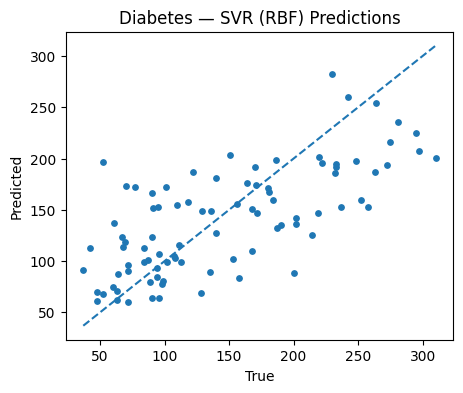

In [8]:

import numpy as np
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

# 1) Load regression data
X, y = load_diabetes(return_X_y=True)

# 2) Train/Val/Test split
X_tmp, X_test, y_tmp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_tmp, y_tmp, test_size=0.25, random_state=42)

# 3) Scale X (and scale y to make epsilon/C meaningful)
x_scaler = StandardScaler().fit(X_train)
Xtr_s, Xval_s, Xte_s = x_scaler.transform(X_train), x_scaler.transform(X_val), x_scaler.transform(X_test)

y_scaler = StandardScaler().fit(y_train.reshape(-1,1))
ytr_s  = y_scaler.transform(y_train.reshape(-1,1)).ravel()
yval_s = y_scaler.transform(y_val.reshape(-1,1)).ravel()

# 4) Manual search over (C, gamma, epsilon)
grid = {
    "C": [0.3, 1, 3, 10, 30],
    "gamma": [0.001, 0.01, 0.1, 1],
    "epsilon": [0.01, 0.05, 0.1, 0.3]
}
best_rmse, best_params = np.inf, None
for C in grid["C"]:
    for gamma in grid["gamma"]:
        for eps in grid["epsilon"]:
            model = SVR(kernel='rbf', C=C, gamma=gamma, epsilon=eps)
            model.fit(Xtr_s, ytr_s)
            pred_val_s = model.predict(Xval_s)
            # compute RMSE on original scale
            pred_val = y_scaler.inverse_transform(pred_val_s.reshape(-1,1)).ravel()
            cur_rmse = rmse(y_val, pred_val)
            if cur_rmse < best_rmse:
                best_rmse, best_params = cur_rmse, (C, gamma, eps)

print(f"Best val RMSE={best_rmse:.2f} with C={best_params[0]}, gamma={best_params[1]}, eps={best_params[2]}")

# 5) Refit on TRAIN+VAL with fresh scalers
X_trval = np.vstack([X_train, X_val])
y_trval = np.hstack([y_train, y_val])

x_scaler2 = StandardScaler().fit(X_trval)
y_scaler2 = StandardScaler().fit(y_trval.reshape(-1,1))

X_trval_s = x_scaler2.transform(X_trval)
X_te_s    = x_scaler2.transform(X_test)
y_trval_s = y_scaler2.transform(y_trval.reshape(-1,1)).ravel()

final = SVR(kernel='rbf', C=best_params[0], gamma=best_params[1], epsilon=best_params[2])
final.fit(X_trval_s, y_trval_s)

pred_te_s = final.predict(X_te_s)
pred_te   = y_scaler2.inverse_transform(pred_te_s.reshape(-1,1)).ravel()

rmse_test = rmse(y_test, pred_te)
r2   = r2_score(y_test, pred_te)
print(f"Test RMSE={rmse_test:.2f}, R^2={r2:.3f}")

# 6) Predicted vs True plot
plt.figure(figsize=(5,4))
plt.scatter(y_test, pred_te, s=15)
lims = [min(y_test.min(), pred_te.min()), max(y_test.max(), pred_te.max())]
plt.plot(lims, lims, linestyle='--')
plt.xlabel("True")
plt.ylabel("Predicted")
plt.title("Diabetes — SVR (RBF) Predictions")
plt.show()



## Lab A2 — Text classification (TF-IDF + LinearSVC, no Pipeline)
**Concepts**: bag-of-words features, linear SVM for high-dim text, top tokens per class.  
**Data**: 4 newsgroups (auto-downloaded on first run).


In [9]:

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
import numpy as np

cats = ['sci.space', 'rec.sport.baseball', 'comp.graphics', 'talk.politics.mideast']

# 1) Load train/test splits
train = fetch_20newsgroups(subset='train', categories=cats, remove=('headers','footers','quotes'))
test  = fetch_20newsgroups(subset='test',  categories=cats, remove=('headers','footers','quotes'))

# 2) Vectorize text (fit on TRAIN only)
vec = TfidfVectorizer(stop_words='english', max_df=0.5, min_df=3)
Xtr = vec.fit_transform(train.data)
Xte = vec.transform(test.data)

# 3) Train linear SVM
clf = LinearSVC(C=1.0, dual=True, max_iter=5000, random_state=42)
clf.fit(Xtr, train.target)

# 4) Evaluate
print(classification_report(test.target, clf.predict(Xte), target_names=cats))

# 5) Show top words per class
feature_names = vec.get_feature_names_out()
for class_idx, class_name in enumerate(cats):
    coefs = clf.coef_[class_idx]
    top10 = np.argsort(coefs)[-10:][::-1]
    print(f"\nTop terms for '{class_name}':")
    print(", ".join(feature_names[top10]))


                       precision    recall  f1-score   support

            sci.space       0.92      0.89      0.90       389
   rec.sport.baseball       0.84      0.93      0.88       397
        comp.graphics       0.90      0.84      0.87       394
talk.politics.mideast       0.93      0.91      0.92       376

             accuracy                           0.89      1556
            macro avg       0.90      0.89      0.89      1556
         weighted avg       0.89      0.89      0.89      1556


Top terms for 'sci.space':
graphics, image, computer, 3d, file, hi, 68070, virtual, 3do, package

Top terms for 'rec.sport.baseball':
baseball, stadium, game, cubs, team, players, games, year, play, season

Top terms for 'comp.graphics':
space, orbit, nasa, moon, spacecraft, launch, solar, shuttle, dc, flight

Top terms for 'talk.politics.mideast':
israel, israeli, loser, jews, turkish, people, retarded, arab, turkey, lebanon



## Lab A3 — Imbalanced classes (class_weight + PR AUC)
**Concepts**: imbalanced datasets, why accuracy can lie, `class_weight='balanced'`, precision-recall curves.


Baseline AP (area under PR curve): 0.554


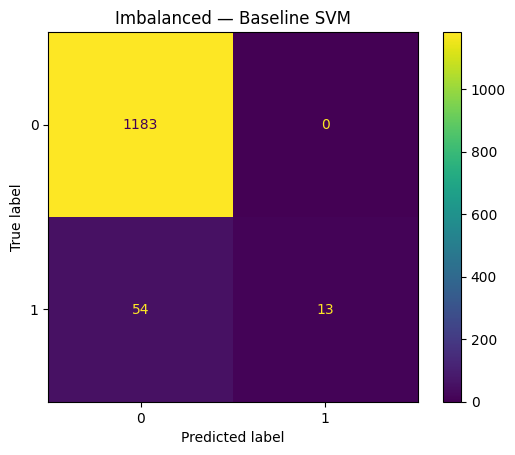

Balanced AP: 0.452


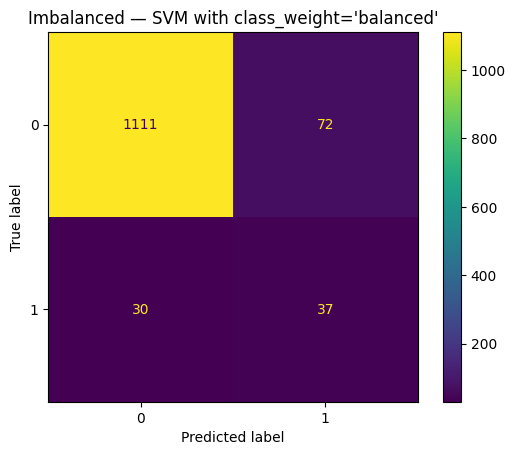

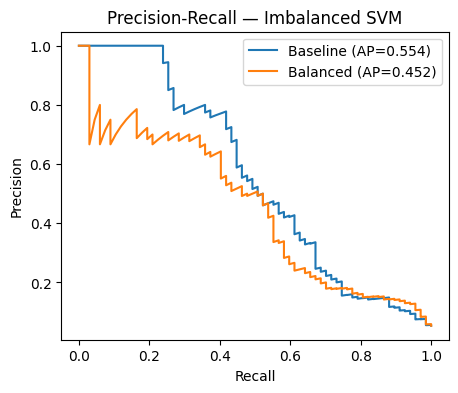

In [10]:

import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, average_precision_score, precision_recall_curve
import matplotlib.pyplot as plt

# 1) Create an imbalanced problem (5% positives)
X, y = make_classification(n_samples=5000, n_features=20, n_informative=6,
                           weights=[0.95, 0.05], flip_y=0.01, class_sep=1.0,
                           random_state=42)

# 2) Split & scale
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)
scaler = StandardScaler().fit(Xtr)
Xtr_s, Xte_s = scaler.transform(Xtr), scaler.transform(Xte)

# 3) Baseline SVM (no balancing)
base = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
base.fit(Xtr_s, ytr)
pred_b = base.predict(Xte_s)
cm_b = confusion_matrix(yte, pred_b)
aps_b = average_precision_score(yte, base.decision_function(Xte_s))
print("Baseline AP (area under PR curve):", round(aps_b, 3))
ConfusionMatrixDisplay(cm_b).plot()
plt.title("Imbalanced — Baseline SVM"); plt.show()

# 4) Balanced SVM
bal = SVC(kernel='rbf', C=1.0, gamma='scale', class_weight='balanced', random_state=42)
bal.fit(Xtr_s, ytr)
pred_bal = bal.predict(Xte_s)
cm_bal = confusion_matrix(yte, pred_bal)
aps_bal = average_precision_score(yte, bal.decision_function(Xte_s))
print("Balanced AP:", round(aps_bal, 3))
ConfusionMatrixDisplay(cm_bal).plot()
plt.title("Imbalanced — SVM with class_weight='balanced'"); plt.show()

# 5) PR curves to compare
prec_b, rec_b, _ = precision_recall_curve(yte, base.decision_function(Xte_s))
prec_bal, rec_bal, _ = precision_recall_curve(yte, bal.decision_function(Xte_s))
plt.figure(figsize=(5,4))
plt.plot(rec_b, prec_b, label=f"Baseline (AP={aps_b:.3f})")
plt.plot(rec_bal, prec_bal, label=f"Balanced (AP={aps_bal:.3f})")  # fixed
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Precision-Recall — Imbalanced SVM")
plt.legend(); plt.show()



---
## Cheat sheet & tips
- `SVC(kernel='linear')` vs `LinearSVC`: both linear but different solvers; `LinearSVC` is often faster on many features.
- `SVC(kernel='rbf')` is a strong default for nonlinear problems.
- **Scaling**: always fit scaler on training only; reuse it for val/test.
- **Tuning**: vary `C` (0.1→100) and for RBF vary `gamma` (0.01→1). For SVR add `epsilon`.
- **Imbalance**: prefer PR/ROC over raw accuracy; try `class_weight='balanced'`.
- **Performance**: For very large datasets, consider `LinearSVC` or `SGDClassifier(loss='hinge')`.
